In [5]:
import os
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import face_recognition
from sklearn import neighbors
import pickle
from face_recognition.face_recognition_cli import image_files_in_folder

%matplotlib inline

def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    
    X = []
    y = []

    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)
    
    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf
    
# train
print("Start Training...")
classifier = train("Detection/data/trainSet", model_save_path="trained_knn_model.clf", n_neighbors=2)
print("Training complete!")


Start Training...
Training complete!


Looking for faces in Aaron.jpg
- Found Aaron_Peirsol at (76, 86)
Finished!
Looking for faces in Abdoulaye.jpg
Found No Face


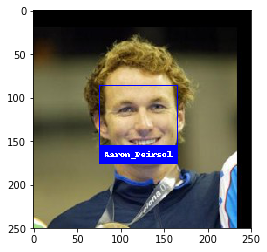

In [15]:
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test image
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

def show_prediction_labels_on_image(img_path, predictions):

    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)

    for name, (top, right, bottom, left) in predictions:

        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
        name = name.encode("UTF-8")

        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))

    del draw
    
    plt.imshow(pil_image)

#test

test_path = "Detection/data/testSet"

for image_file in os.listdir(test_path):
    
    full_file_path = os.path.join(test_path, image_file)
    
    print("Looking for faces in {}".format(image_file))
    
    predictions = predict(full_file_path, model_path="trained_knn_model.clf")
    
    if predictions:
        for name, (top, right, bottom, left) in predictions:
            print("- Found {} at ({}, {})".format(name, left, top))
        show_prediction_labels_on_image(os.path.join(test_path, image_file), predictions)
        print("Finished!")
    else:
        print("Found No Face")
